# 三、分类

In [1]:
# !jupyter labextension install @jupyterlab/toc
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

### 使用代码下载该数据集

In [2]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def digit_show(some_digit):
    some_digit_image = some_digit.reshape(28,28)

    plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

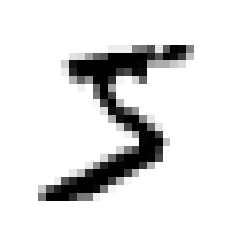

5


In [5]:
digit_show(X[0])
print(y[0])

In [6]:
y[0]

'5'

In [7]:
y=y.astype(np.uint8)

In [8]:
y[0]

5

### 划分训练集、测试集、将测试集放一边

In [9]:
# # 先shuffle
# import random
# combined = list(zip([1,2,3], [4,5,6]))
# random.shuffle(combined)
# list(zip(*combined))

[(3, 2, 1), (6, 5, 4)]

In [10]:
# 划分
index = 60000
X_train, X_test, y_train, y_test = X[:index], X[index:], y[:index], y[index:]

### 训练一个二分类器

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
print(sgd_clf.predict([X_train[0]]))
print(y_train[0])

[ True]
5


### perfomance measures:评估表现

1. 用CV来评估：cross_val_score()
2. confusion matrix:混淆矩阵
    * precision and recall

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# 得看看是不是严重不平衡
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [17]:
# 使用混淆矩阵
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [19]:
# precision 、recall and f1_score
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343846


In [20]:
# precision_recall curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

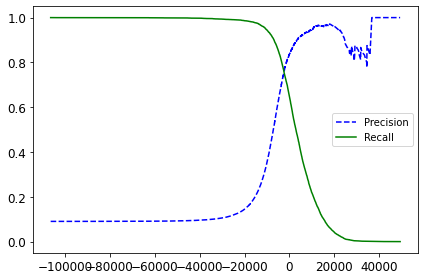

In [21]:
def plot_precision_recall_vs_threhold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

plot_precision_recall_vs_threhold(precisions, recalls, thresholds)

In [22]:
# 使精确率达到90%的阈值
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))
print(f1_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706
0.626082771896054


In [23]:
# roc_curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

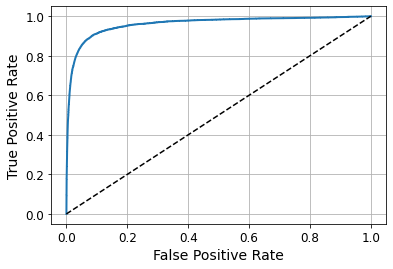

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()

plot_roc_curve(fpr, tpr)

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### 随机森林

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [28]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

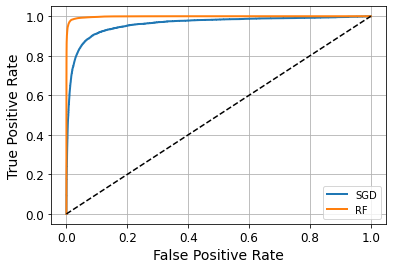

In [29]:
plt.plot(fpr, tpr,linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='RF')
plt.legend()
plt.show()

In [30]:
print(roc_auc_score(y_train_5, y_scores_forest))
print(precision_score(y_train_5, y_scores_forest>=0.5))
print(recall_score(y_train_5, y_scores_forest>=0.5))
print(f1_score(y_train_5, y_scores_forest>=0.5))

0.9983436731328145
0.9897468089558485
0.8725327430363402
0.9274509803921569


### 二分类总结

1. 选择一个合适的评估指标
2. 用CV交叉验证来执行分类模型
3. 选择precision\recall来避免陷阱
3. 用roc和auc比较不同模型

### 多类别分类

* 一个行记录只属于多类别中的一个类别

1. ovo：拆成N*(N-1)/2个分类，例如类别1vs类别2，类别1vs类别3，...
2. ovr: 拆成N个分类，例如类别1vs剩下，类别2vs剩下，...

In [31]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
some_digit = X_train[0]
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [32]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [33]:
np.argmax(some_digit_scores)

3

In [34]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [35]:
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

In [36]:
# 标准化处理
from sklearn.preprocessing import StandardScaler

In [37]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

### 错误率分析

In [38]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
# conf_mx = confusion_matrix(y_train, y_train_pred)
# conf_mx

In [39]:
# plt.matshow(conf_mx, cmap=plt.cm.gray)
# plt.show()

In [40]:
# row_sums = conf_mx.sum(axis=1, keepdims=True)
# norm_conf_mx = conf_mx / row_sums
# np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
# plt.show()

In [41]:
# # 分析3、5的差别
# def plot_digits(instances, images_per_row=10, **options): 
#     size = 28 
#     images_per_row = min(len(instances), images_per_row) 
#     images = [instance.reshape(size,size) for instance in instances] 
#     n_rows = (len(instances) - 1) // images_per_row + 1 
#     row_images = [] 
#     n_empty = n_rows * images_per_row - len(instances) 
#     images.append(np.zeros((size, size * n_empty)))  
#     for row in range(n_rows): 
#         rimages = images[row * images_per_row : (row + 1) * images_per_row] 
#         row_images.append(np.concatenate(rimages, axis=1)) 
#     image = np.concatenate(row_images, axis=0) 
#     plt.imshow(image, cmap = plt.cm.binary, **options) 
#     plt.axis("off") 

In [42]:
# cl_a, cl_b = 3, 5
# X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
# X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]

# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# plt.show()

### 多标签分类

* 一个行记录可能属于多个类别，例如一个人是男人、律师

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [45]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [46]:
knn_clf.predict([some_digit])

array([[False,  True]])

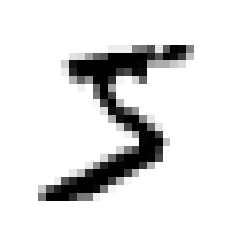

In [47]:
digit_show(some_digit)

#### 评估多标签分类器

* 一个方法是对每个个体标签度量F1_score，然后计算平均值

In [48]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [49]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

### 多输出-多类分类

* 一个标签可以是多类别的
* 例如：分类器的输出是多标签（一个像素一个标签），而每个标签可以有多个值，类标签和值标签

In [50]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
y_train_mod = X_train
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_test_mod = X_test

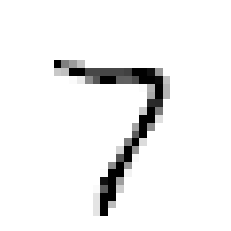

In [51]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
digit_show(clean_digit)

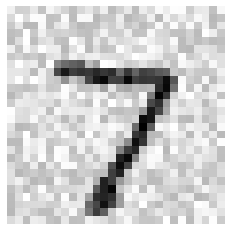

In [52]:
digit_show(X_test_mod[0])

## 练习题

### 1
1. 尝试在MNIST数据集上建立一个分类器，使它在测试集上的精度超过97%
    * 提示：使用KNeighborsClassifier，找出一个好的超参数，（对权重和超参数n_neighbors进行网格搜索）

In [16]:
# 导入数据
# from sklearn.datasets import fetch_openml
# # Load data from https://www.openml.org/d/554
# X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(X.shape, y.shape)

# 划分训练集、测试集
import numpy as np
y = y.astype(np.uint8)

index = 55000
X_train, y_train, X_test, y_test = X[:index], y[:index], X[index:], y[index:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# 画图查看其中一条记录
import matplotlib as mpl
import matplotlib.pyplot as plt

index = 0
tmp = X[index].reshape((28, 28))
plt.imshow(tmp, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

y[0]

# 建立分类器
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_5)
pred = knn_clf.predict(X_test)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_5, pred)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(accuracy_score(y_test_5, pred))
print(precision_score(y_test_5, pred))
print(recall_score(y_test_5, pred))
print(f1_score(y_test_5, pred))

# 使用gridcv来进行超参数筛选
from sklearn.model_selection import GridSearchCV

para_grid = [{'n_neighbors': [3,4,5], 'weights': ['uniform', 'distance']}]
knn_fit = KNeighborsClassifier()
grid_search = GridSearchCV(knn_fit, para_grid, cv=5)
grid_search.fit(X_train, y_train_5)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

# 评估评分
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(mean_score), params)

# 预测
pred = grid_search.predict(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(accuracy_score(y_test_5, pred))
print(precision_score(y_test_5, pred))
print(recall_score(y_test_5, pred))
print(f1_score(y_test_5, pred))

### 2
2. 拿Titanic 数据集去捣鼓一番。开始这个项目有一个很棒的平台：Kaggle！